In [200]:
import jax

import jax.numpy as jnp
import numpy as np
from typing import NamedTuple,Optional
import matplotlib.pyplot as plt
np.random.seed(123)
S = 8 #state_size
A = 4  #action_size
S_array = np.arange(S) #state_set
A_array = np.arange(A) #action_set
gamma = 0.99

rew = np.random.rand(S,A) #報酬

P = np.random.rand(S,A, S) #遷移確率
P = P / np.sum(P,axis=-1,keepdims=True)
P = P.reshape(S,A,S)
np.testing.assert_almost_equal(P.sum(axis=-1),1) #確率1になっているか確認

# MDPの定義

class MDP(NamedTuple):
    S_array : np.array
    A_array : np.array
    gamma : float
    rew : np.array
    P : np.array
    horizon : int

    @property
    def S(self) -> int:
        return len(self.S_array)

    @property
    def A(self) -> int:
        return len(self.A_array)

horizon = int(1 / (1 - gamma))
mdp = MDP(S_array,A_array,gamma,rew,P,horizon)
print(mdp.rew.shape)
print(mdp.P.shape)
print(mdp.S)

(8, 4)
(8, 4, 8)
8


In [209]:
import numpy as np

def quantile_dynamic_programming(theta:np.ndarray, mdp:MDP, gamma:float) -> np.array:
    """
    Quantile Dynamic Programming

    Parameters
    ----------
    theta : np.array
        quantile function
    mdp : MDP
        MDP
    gamma : float
        discount factor

    Returns
    -------
    theta_prime : np.array
        next quantile function

    """
    m = theta.shape[1]

    theta_prime = np.zeros_like(theta)

    for x in range(mdp.S):
        targets = {'outcome': [], 'probability': []}
        for x_prime in range(mdp.S):
            for j in range(m):
                action_index = np.argmax(mdp.rew[x])
                new_theta = mdp.rew[x, action_index] + gamma * theta[x_prime, j]
                probability = mdp.P[x, action_index, x_prime]
                targets['outcome'].append(new_theta)
                targets['probability'].append(probability)

        #分位点を中心に考えてるので、ソートして累積分布を求められる
        sorted_indices = np.argsort(targets['outcome'])
        outcomes = np.array(targets['outcome'])[sorted_indices]
        probabilities = np.array(targets['probability'])[sorted_indices]

        cumulative_probability = 0
        for i in range(1, m + 1):
            target_index = 0
            while cumulative_probability < (2 * i - 1) / 2 :
                #i番目の分位を遷移確率が超えるまで足し、その中で超えない最大のindex分位として採用
                cumulative_probability += probabilities[target_index]
                target_index += 1

            q_prime = outcomes[target_index - 1]
            theta_prime[x, i - 1] = q_prime

    return theta_prime



In [210]:
def V_Iteration(mdp: MDP):
    S,A = mdp.S,mdp.A
    Q = np.zeros((S,A))
    policy = np.zeros((S,A))
    for s in range(S):
        for a in range(A):
            for s_dash in range(S):
                Q[s,a] = mdp.rew[s,a] + mdp.gamma * mdp.P[s,a,s_dash] * np.max(Q[s_dash,:])
    V = np.max(Q,axis=-1)
    return V

In [211]:
m = 5
theta = np.zeros((mdp.S, m))

re = quantile_dynamic_programming(theta, mdp, gamma)
V_tau = re.sum(axis=-1)/m
V = V_Iteration(mdp)
np.max(np.abs(V-V_tau))

0.10184606604363478

In [204]:
m = 100
theta = np.zeros((mdp.S, m))

re = quantile_dynamic_programming(theta, mdp, gamma)
V_tau = re.sum(axis=-1)/m
V = V_Iteration(mdp)
np.max(np.abs(V-V_tau))

0.10184606604363466

In [205]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_dif_quantile(mdp: MDP, gamma: float, m_list: list):
    V = V_Iteration(mdp)
    dif_list = []
    for m in m_list:
        theta = np.zeros((mdp.S, m))
        result = quantile_dynamic_programming(theta, mdp, gamma)
        result = result.mean(axis=-1)
        dif = np.max(np.abs(V - result))
        dif_list.append(dif)
    plt.figure(figsize=(10, 5))
    plt.scatter(m_list, dif_list)
    plt.xlabel('m values')
    plt.ylabel('Error')
    plt.title('Difference from V_Iteration for Different m values')
    plt.show()
    return dif_list

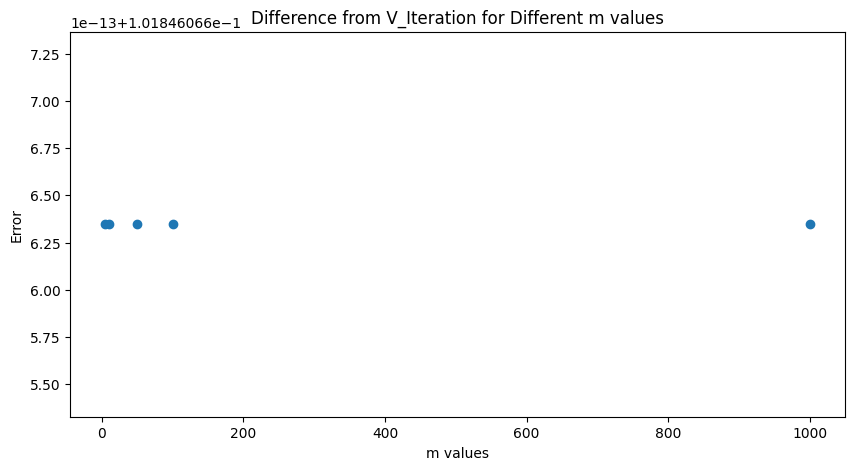

In [206]:
gamma = 0.99
m_list = [5,10,50,100,1000]
dif = plot_dif_quantile(mdp, gamma, m_list)

In [207]:
dif

[0.10184606604363478,
 0.10184606604363478,
 0.10184606604363466,
 0.10184606604363466,
 0.10184606604363466]

In [194]:
dif[0] - dif[3]

-1.1102230246251565e-16